In [1]:
import pandas as pd
import numpy as np
import lasio
import matplotlib.pyplot as plt
las = lasio.read(r'1050383876.las')

In [3]:
#Headers and units of the las file
las.curves

[CurveItem(mnemonic="DEPT", unit="FT", value="0 000 00 00", descr="Depth", original_mnemonic="DEPT", data.shape=(7056,)),
 CurveItem(mnemonic="CNPOR", unit="PU", value="0", descr="CN Selected Porosity", original_mnemonic="CNPOR", data.shape=(7056,)),
 CurveItem(mnemonic="DCAL", unit="IN", value="0", descr="Caliper from Density Tool", original_mnemonic="DCAL", data.shape=(7056,)),
 CurveItem(mnemonic="DPOR", unit="PU", value="0", descr="Density Porosity", original_mnemonic="DPOR", data.shape=(7056,)),
 CurveItem(mnemonic="GR", unit="GAPI", value="0", descr="Gamma Ray", original_mnemonic="GR", data.shape=(7056,)),
 CurveItem(mnemonic="RHOB", unit="G/CC", value="0", descr="Bulk Density", original_mnemonic="RHOB", data.shape=(7056,)),
 CurveItem(mnemonic="RHOC", unit="G/CC", value="0", descr="Density Correction", original_mnemonic="RHOC", data.shape=(7056,)),
 CurveItem(mnemonic="RILD", unit="OHM-M", value="0", descr="DIL Deep Resistivity", original_mnemonic="RILD", data.shape=(7056,)),
 C

In [4]:
df = las.df() 

In [5]:
df.columns

Index(['CNPOR', 'DCAL', 'DPOR', 'GR', 'RHOB', 'RHOC', 'RILD', 'RILM', 'RLL3',
       'RXORT', 'SP', 'MEL15', 'MEL20', 'DT', 'ITT', 'MELCAL', 'SPOR'],
      dtype='object')

In [6]:
#Extracting RHOB & DT to generate Synthetic Seismogram
df_selected = df[['RHOB', 'DT']]

In [7]:
#number of NaN in each columns
df_selected.isna().sum(axis=0)

RHOB    2026
DT        51
dtype: int64

In [8]:
df_dropped = df_selected.dropna(subset=['RHOB', 'DT'],axis=0, how='any')

In [9]:
#Filtering
df_dropped = df_dropped.loc[(df_dropped.RHOB> 1) & (df_dropped.RHOB<= 3)]
df_dropped = df_dropped.loc[(df_dropped.DT > 30) & (df_dropped.DT <= 140)]

In [10]:
df_idx = df_dropped.rename_axis('Depth').reset_index()
df_idx.head()

,Depth,RHOB,DT
0,1000.0,2.9297,51.7747
1,1000.5,2.9385,51.9790
2,1001.0,2.9348,52.0958
3,1001.5,2.9106,52.1265
4,1002.0,2.8825,52.0743


In [11]:
def log_plot(logs):
    logs = logs.sort_values(by='Depth')
    top = logs.Depth.min()
    bot = logs.Depth.max()
    
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,20))
    ax[0].plot(logs.DT, logs.Depth, color='black')
    ax[1].plot(logs.RHOB, logs.Depth, color='brown')
    
    
    for i in range(len(ax)):
        ax[i].set_ylim(top,bot)
        ax[i].invert_yaxis()
        ax[i].grid()
        

    ax[0].set_ylabel("Depth(ft)")

    ax[0].set_xlabel("DT")
    ax[0].set_xlim(logs.DT.min(),logs.DT.max())
    ax[1].set_xlabel("RHOB")
    ax[1].set_xlim(logs.RHOB.min(),logs.RHOB.max())

    
    ax[0].set_yticklabels([])
    ax[1].set_yticklabels([])
 
    f.suptitle('Density & Sonic Log', fontsize=14,y=0.89)

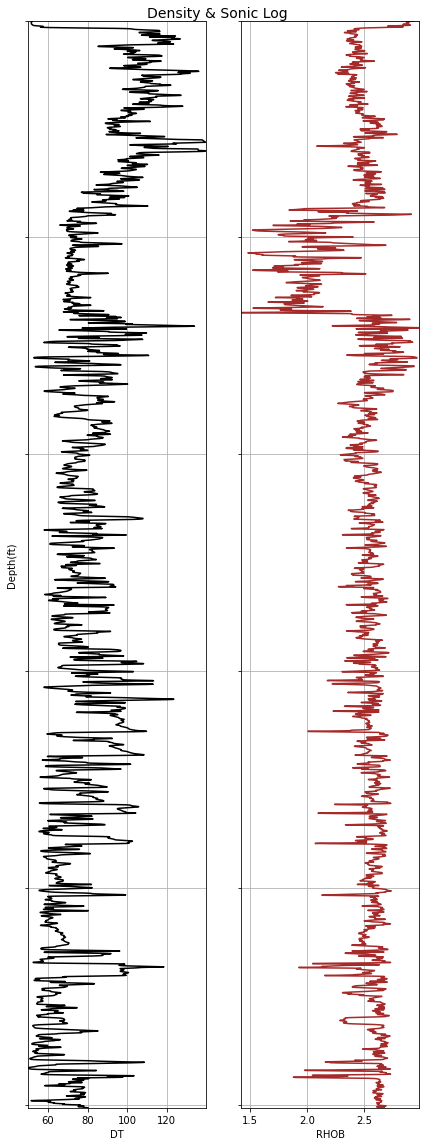

In [12]:
log_plot(df_idx)

In [13]:
seismo = df_idx.copy()

In [14]:
seismo['RHOB']=seismo['RHOB']*1000  #kg/m2

In [15]:
seismo['DT'] = seismo['DT'] / 0.3048   #unit convert to µs/m
seismo['Vsonic'] = 1e6/seismo.DT        #conversion to m/s

In [16]:
#Accoustic Impedence
seismo['AI'] = seismo['Vsonic'] * seismo['RHOB'] 

In [17]:
#TWT
seismo['TWT']= 2*seismo['Depth']/seismo['Vsonic']

In [18]:
Imp = seismo['AI'].values
Rc=[]
for i in range(len(Imp)-1):
    Rc.append((Imp[i+1]-Imp[i])/(Imp[i]+Imp[i+1]))

#Reflectivity coefficient
Rc.append(Rc[-1])

In [19]:
seismo['Rc'] = pd.Series(Rc, index=seismo.index)

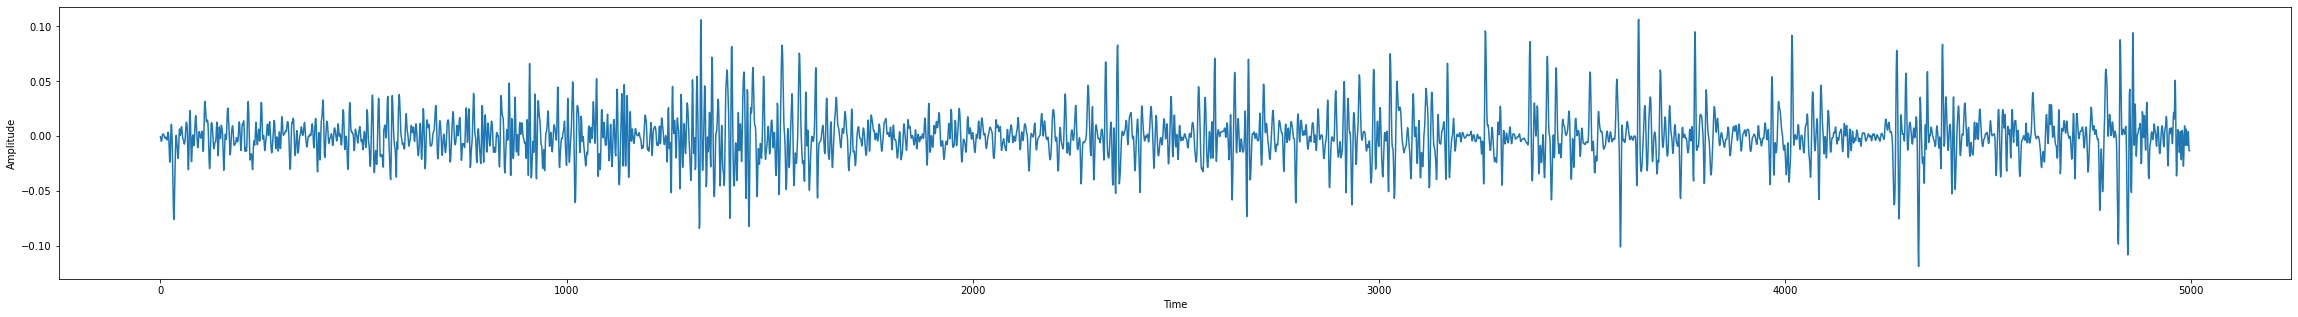

In [21]:
fig = plt.figure()
fig.set_figwidth(40)
fig.set_figheight(5)
plt.xlabel("Time") #Couldn't convert domain to time {assuming depth to be time}
plt.ylabel("Amplitude")
plt.plot(seismo['Rc'])

In [22]:
#Convultion using Ricker Wavelet
def ricker(f, length, dt):
    t0 = np.arange(-length/2, (length-dt)/2, dt)
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*(t0**2)) * np.exp(-(np.pi**2)*(f**2)*(t0**2))
    return t0, y

In [27]:
N = len(df['RHOB'])/2

In [26]:
f=30          #wavelet frequency
length=0.512    #Wavelet vector length
dt=0.002        # Sampling prefer to use smiliar to resampled AI
t0, w = ricker (f, length, dt) 
synthetic_30 = np.convolve(w, Rc, mode='same')

In [28]:
f=60          #wavelet frequency
length=0.512    #Wavelet vector length
dt=0.002        
t0, w = ricker (f, length, dt) 
synthetic_60 = np.convolve(w, Rc, mode='same')

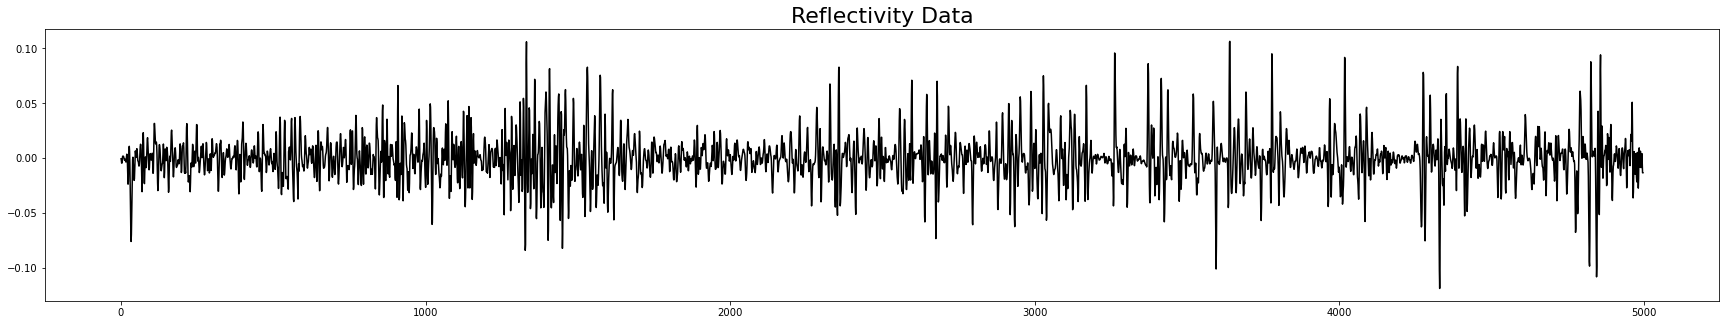

In [30]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(5)
plt.title("Reflectivity Data", fontsize= 22)
plt.plot(seismo['Rc'],color='black')

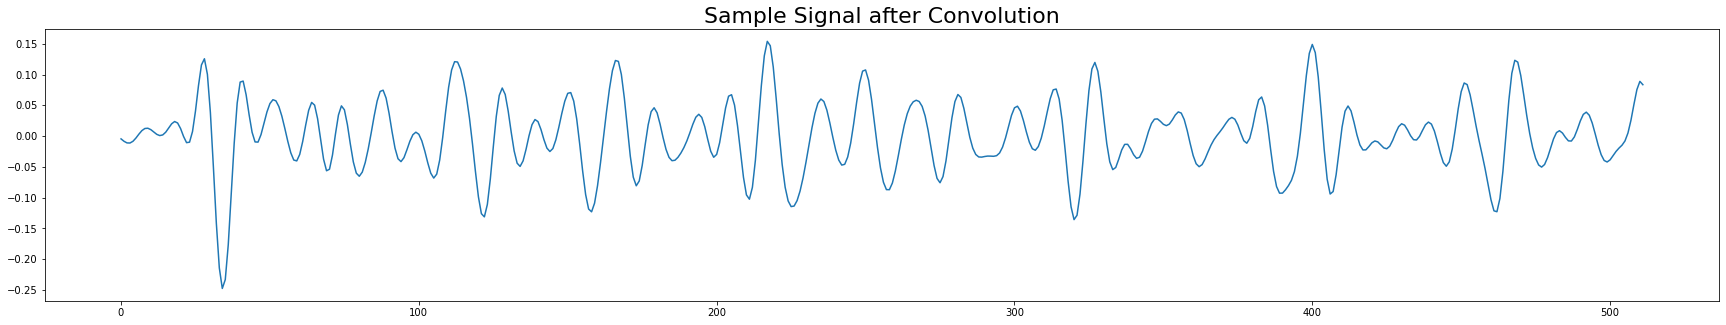

In [34]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(5)
plt.title("Sample Signal after Convolution", fontsize= 22)
plt.plot(synthetic_30[:512])
